In [96]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
import lib.utils_RSA as rsa
from lib.algos import *
from scipy.spatial import procrustes as scipro


In [107]:
dataset = 'ecoVal'
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random']
path2activations = f'/data/alban/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))



In [108]:
activations['saycam'].shape

(28250, 768)

In [99]:
RDMs = {}
for i, model in enumerate(models):
    RDMs[model] = 1 - np.corrcoef(activations[model])


In [100]:
SIMs = {}
#for model in models:
#    SIMs[model] = {}
#for i, model1 in enumerate(models[:-1]):
#    for j, model2 in enumerate(models[i+1:]):
#        SIMs[model1][model2] = list()
#        SIMs[model1][model2].append(rsa.Compute_sim_RDMs(RDMs[model1], RDMs[model2]))



In [101]:
SIMs

{}

In [102]:
## Run custom procrustes analysis
d, Z, T = procrustes(activations['saycam'], activations['ego'])
## Run scipy procrustes analysis as a control
mtx1, mtx2, dsci = scipro(activations['saycam'], activations['ego'])
print([d, dsci])
## --> Both algos agree with each other, and the disparity measures are pretty high (somewhat unexpectedly)

[np.float32(0.7038437), np.float64(0.7038432856958128)]


In [109]:
### check if images were shown in the same order
imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[7]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

np.array(imagelist).reshape(-1, nb_per_cat)[0]



array(['/raid/shared/datasets/visoin/ecoset/val/0001_man/n09641002_18604.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09895480_2584.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09895480_3294.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09924195_1450.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09924195_2260.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09924195_8262.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n09924195_9627.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n10056719_1119.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n10056719_4339.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n10289039_13578.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n10289039_22340.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/0001_man/n10289039_23455.JPEG',
       '/raid/shared/datasets/visoin/ecoset/val/

In [110]:
### reshape activations according to categoreis
shape = activations[models[0]].shape
cat_activations = activations.copy()
for model in models:
  cat_activations[model] = cat_activations[model].reshape(-1, nb_per_cat, shape[-1])

### do some stats
sorted_stats = {}
sorted_cats = {}
for model in models:
    std = np.std(cat_activations[model], axis = (0,1))
    cat_std = np.std(cat_activations[model], axis = 1)
    normalized_cat_std = cat_std/std
    mean_normalized_cat_std = normalized_cat_std.mean(-1)
    sorted_stats[model] = np.sort(mean_normalized_cat_std)
    sorted_cats[model] = np.array(listcat)[np.argsort(mean_normalized_cat_std)]

In [111]:
import math
def plot_stats(SIMs, submodels, labels = ['label1', 'label2']):
    '''plot the similarities as a function of layer depth.
    Plot is a subplot of adaptative size, depending on the length of the list submodel given.
    '''
    nb_subs = len(submodels) # Number of subs
    sqrt = np.sqrt(nb_subs)
    cols = math.ceil(sqrt)
    rows = math.ceil(nb_subs // sqrt)
    while (cols*rows)<(nb_subs):
        rows =rows + 1 ## compute the number of columns and rows
    fig, subs = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(cols*2+1, rows*2+1)) # adaptative size
    count = 0
    minval = 1
    maxval = 0
    for i, model in enumerate(submodels):
        minval = min(minval, np.amin(SIMs[model]))
        maxval = max(maxval, np.amax(SIMs[model]))
        if rows ==1:
            subs[count%cols].plot(SIMs[model])
            subs[count%cols].set_title(f'{model}')
        else:
            subs[count//cols, count%cols].plot(SIMs[model])
            subs[count//cols, count%cols].set_title(f'{model}')
            count+=1
    plt.ylim(np.round(minval,1)-0.1, np.round(maxval,1)+0.1)
    if rows == 1:
        subs[0].set_ylabel(labels[1])
        for sub in subs:
            sub.set_xlabel(labels[0])
    else:
        for sub in subs[-1]:
            sub.set_xlabel(labels[0])
        for sub in subs[:,0]:
            sub.set_ylabel(labels[1])
    fig.tight_layout()
    plt.show()
    plt.close()

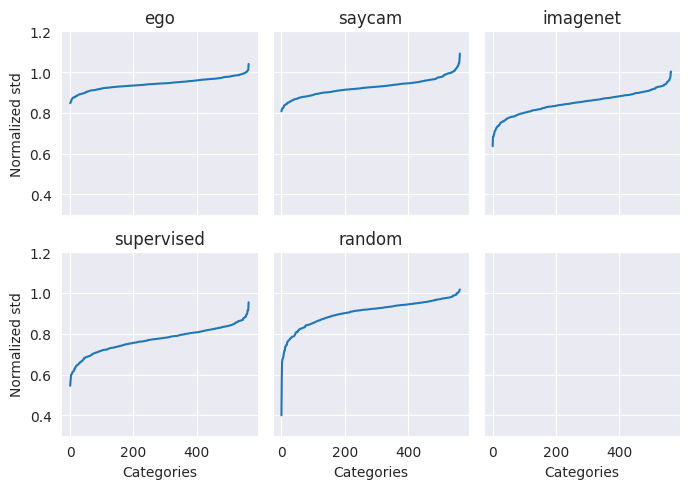

['2400_geyser' '2144_newsstand' '0089_bus' '0517_bumblebee'
 '0659_carousel' '0617_taco' '0082_kitchen' '0857_waterfall' '0009_car'
 '1335_dragonfly' '1073_fireworks' '0240_microscope' '0443_snowplow'
 '1655_steamroller' '1892_panda' '1043_mall' '0265_steak' '0209_leopard'
 '0137_train' '1156_nacho']
['1892_panda' '2400_geyser' '1515_waterspout' '1367_sphinx' '0082_kitchen'
 '2112_photocopier' '1135_hamster' '1612_forklift' '0185_hamburger'
 '1787_koala' '0857_waterfall' '0488_iceberg' '0443_snowplow'
 '1073_fireworks' '0257_burrito' '0265_steak' '0617_taco' '1409_brownie'
 '0292_lion' '1245_custard']
['2400_geyser' '0443_snowplow' '0082_kitchen' '0847_jaguar' '1367_sphinx'
 '1892_panda' '0857_waterfall' '1515_waterspout' '0240_microscope'
 '1335_dragonfly' '2144_newsstand' '2972_rainbow' '0764_gondola'
 '0089_bus' '0867_bulldozer' '0617_taco' '1612_forklift' '1374_canyon'
 '1129_zebra' '2009_graffiti']
['0847_jaguar' '0240_microscope' '1892_panda' '2527_helicopter'
 '0209_leopard' '20

In [112]:
plot_stats(sorted_stats,models,  ['Categories', 'Normalized std'])
for model in models:
    print(sorted_cats[model][:20])
for model in models:
    print(sorted_cats[model][-20:])

In [117]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return set1 == set2, f"{proportion:.2f}%"

for model in models[:]:
    print(check_list_similarity(sorted_cats['saycam'][:50],sorted_cats[model][:50]))

for model in models[:]:
    print(check_list_similarity(sorted_cats['ego'][:50],sorted_cats[model][:50]))


(False, '52.00%')
(True, '100.00%')
(False, '48.00%')
(False, '24.00%')
(False, '30.00%')
(True, '100.00%')
(False, '52.00%')
(False, '60.00%')
(False, '32.00%')
(False, '32.00%')
